In [1]:
import random
import itertools
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from abc import ABC, abstractmethod

In [2]:
authors_df = pd.read_csv('database_50k/authorships.csv')
works_df = pd.read_csv('database_50k/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

test_ground_truth = defaultdict(set)

for author, coauthors in test_graph_raw.items():
    # Pega quem o autor colaborou no futuro
    future_coauthors = coauthors
    
    # Remove quem ele já conhecia no passado (não é predição nova)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_27184\3401278603.py:2: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv('database_50k/works.csv')


In [3]:
def encontrar_autor_exemplo(grafo, min_coautores=5, max_coautores=15, seed=None):
    if seed is not None:
        random.seed(seed)
        
    candidatos = []
    for node in grafo.nodes():
        grau = grafo.degree(node)
        if min_coautores <= grau <= max_coautores:
            candidatos.append(node)
    
    if candidatos:
        escolhido = random.choice(candidatos)
        print(f"Autor escolhido: {escolhido} (Possui {grafo.degree(escolhido)} coautores diretos)")
        return escolhido
    else:
        print("Nenhum autor encontrado nesse intervalo.")
        return None

In [4]:
def visualizar_rede_ego(grafo, autor_id, profundidade=1):
    if autor_id not in grafo:
        print(f"Autor {autor_id} não encontrado no grafo.")
        return

    subgrafo = nx.ego_graph(grafo, autor_id, radius=profundidade)
    
    plt.figure(figsize=(12, 10))
    
    pos = nx.spring_layout(subgrafo, k=0.5, seed=42) 
    
    nos_centro = [autor_id]
    nos_vizinhos = [n for n in subgrafo.neighbors(autor_id)]
    outros_nos = [n for n in subgrafo.nodes() if n not in nos_centro and n not in nos_vizinhos]
    
    nx.draw_networkx_edges(subgrafo, pos, alpha=0.3, edge_color='gray')
    nx.draw_networkx_nodes(subgrafo, pos, nodelist=nos_centro, node_color='#FF4500', node_size=800, label='Autor Central')
    nx.draw_networkx_nodes(subgrafo, pos, nodelist=nos_vizinhos, node_color='#1E90FF', node_size=300, label='Coautores Diretos')
    
    if outros_nos:
        nx.draw_networkx_nodes(subgrafo, pos, nodelist=outros_nos, node_color='#32CD32', node_size=100, label=f'Camada {profundidade}')

    plt.title(f"Rede de Coautoria: Autor {autor_id} (Profundidade {profundidade})")
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.show()

Grafo criado com 25260 autores e 217493 conexões.
Autor escolhido: https://openalex.org/A5013757342 (Possui 3 coautores diretos)


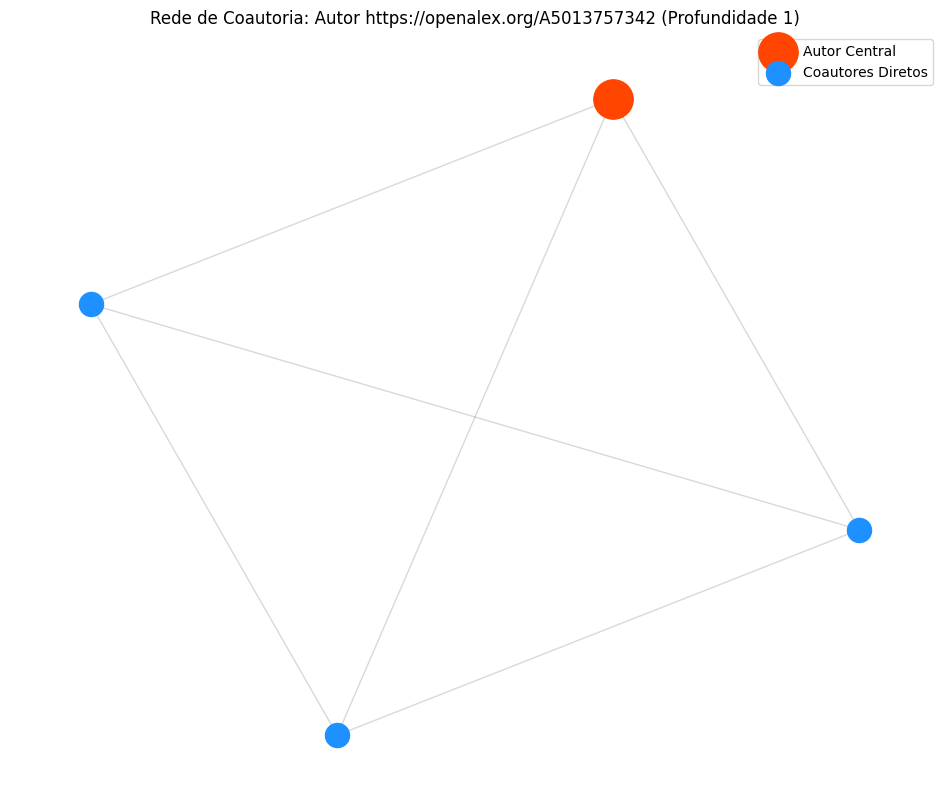

In [5]:
G = nx.Graph(train_graph)

print(f"Grafo criado com {G.number_of_nodes()} autores e {G.number_of_edges()} conexões.")

autor_central = encontrar_autor_exemplo(G, 1, 10, seed=42)
visualizar_rede_ego(G, autor_central, profundidade=1)

In [6]:
def calculate_topology_ceiling_dynamic(train_graph, test_ground_truth, max_hops=3):
    """
    Calcula o Recall Máximo teórico para uma profundidade de N hops.
    """
    hits = 0
    total_new_links = 0
    
    for i, (author_id, actual_new_coauthors) in enumerate(test_ground_truth.items()):
        if author_id not in train_graph:
            total_new_links += len(actual_new_coauthors)
            continue
            
        visited = {author_id}
        current_layer = {author_id}
        
        for _ in range(max_hops):
            next_layer = set()
            for node in current_layer:
                neighbors = train_graph.get(node, set())
                new_neighbors = neighbors - visited
                next_layer.update(new_neighbors)
                visited.update(new_neighbors)
            
            current_layer = next_layer
            if not current_layer: 
                break
        
        candidates = visited
        candidates.discard(author_id)
        candidates = candidates - train_graph.get(author_id, set())
        
        matches = candidates.intersection(actual_new_coauthors)
        hits += len(matches)
        total_new_links += len(actual_new_coauthors)

    max_recall = hits / total_new_links if total_new_links > 0 else 0
    return max_recall, hits, total_new_links


hop_results = {}

for k_hops in range(2, 11):
    recall, found, total = calculate_topology_ceiling_dynamic(train_graph, test_ground_truth, max_hops=k_hops)
    hop_results[k_hops] = recall
    print(f"[HOPS={k_hops}] Encontrados: {found}/{total}")

print("\n=== RESUMO DA EVOLUÇÃO DO ALCANCE ===")
for k, rec in hop_results.items():
    print(f"{k} Hops -> {rec*100:.1f}% das novas conexões são explicáveis")

[HOPS=2] Encontrados: 5174/179973
[HOPS=3] Encontrados: 7686/179973
[HOPS=4] Encontrados: 8822/179973
[HOPS=5] Encontrados: 9002/179973
[HOPS=6] Encontrados: 9006/179973
[HOPS=7] Encontrados: 9006/179973
[HOPS=8] Encontrados: 9006/179973
[HOPS=9] Encontrados: 9006/179973
[HOPS=10] Encontrados: 9006/179973

=== RESUMO DA EVOLUÇÃO DO ALCANCE ===
2 Hops -> 2.9% das novas conexões são explicáveis
3 Hops -> 4.3% das novas conexões são explicáveis
4 Hops -> 4.9% das novas conexões são explicáveis
5 Hops -> 5.0% das novas conexões são explicáveis
6 Hops -> 5.0% das novas conexões são explicáveis
7 Hops -> 5.0% das novas conexões são explicáveis
8 Hops -> 5.0% das novas conexões são explicáveis
9 Hops -> 5.0% das novas conexões são explicáveis
10 Hops -> 5.0% das novas conexões são explicáveis


In [7]:
def diagnose_reachability(train_graph, test_ground_truth):
    stats = {
        "total_links": 0,
        "source_missing_in_train": 0,
        "target_missing_in_train": 0,
        "both_present_but_disconnected": 0,
        "reachable": 0
    }
    
    G = nx.Graph()
    for u, neighbors in train_graph.items():
        for v in neighbors:
            G.add_edge(u, v)
            
    component_map = {}
    for i, component in enumerate(nx.connected_components(G)):
        for node in component:
            component_map[node] = i
            
    
    for author_id, new_coauthors in test_ground_truth.items():
        for target_id in new_coauthors:
            stats["total_links"] += 1
            
            if author_id not in train_graph:
                stats["source_missing_in_train"] += 1
                continue
                
            if target_id not in train_graph:
                stats["target_missing_in_train"] += 1
                continue
                
            comp_source = component_map.get(author_id)
            comp_target = component_map.get(target_id)
            
            if comp_source == comp_target:
                stats["reachable"] += 1
            else:
                stats["both_present_but_disconnected"] += 1

    return stats

# Rodar diagnóstico
diag = diagnose_reachability(train_graph, test_ground_truth)

print("\n=== DIAGNÓSTICO DETALHADO ===")
total = diag["total_links"]
print(f"Total de Novas Conexões Analisadas: {total}")
print(f"1. Autor Origem Novo (Cold Start): {diag['source_missing_in_train']} ({diag['source_missing_in_train']/total:.1%})")
print(f"2. Autor Alvo Novo (Cold Start):   {diag['target_missing_in_train']} ({diag['target_missing_in_train']/total:.1%})")
print(f"3. Ambos Existem, mas Isolados:    {diag['both_present_but_disconnected']} ({diag['both_present_but_disconnected']/total:.1%})")
print(f"4. Tecnicamente Alcançáveis:       {diag['reachable']} ({diag['reachable']/total:.1%})")


=== DIAGNÓSTICO DETALHADO ===
Total de Novas Conexões Analisadas: 179973
1. Autor Origem Novo (Cold Start): 141205 (78.5%)
2. Autor Alvo Novo (Cold Start):   29474 (16.4%)
3. Ambos Existem, mas Isolados:    288 (0.2%)
4. Tecnicamente Alcançáveis:       9006 (5.0%)
